# Balearic Network

In [138]:
import pandas as pd
import geopandas as gpd
import pandapower as pp
import numpy as np
from pandapower import plotting
import matplotlib.pyplot as plt

### Option to run powerflow for present system and future solar PV installation 

In [139]:
#For regular generation, make false:
PV_System_Installed = True 

In [140]:
#DEMAND PER ISLAND
Demand_data                = pd.read_excel("Island Demand.xlsx")
Mallorca_Demand            = Demand_data.iloc[:,1].values.tolist()
Menorca_Demand             = Demand_data.iloc[:,3].values.tolist()
Eivissa_Formentera_Demand  = Demand_data.iloc[:,5].values.tolist()

In [141]:
#PRESENT GENERATION PER TYPE AND ISLAND
Present_Generation = pd.read_excel("Hourly Averaged Installed Generation Data.xlsx")
Menorca_Diesel     = Present_Generation.iloc[:,1].values.tolist()
Menorca_Gas        = Present_Generation.iloc[:,2].values.tolist()
Mallorca_CCGT      = Present_Generation.iloc[:,3].values.tolist()
Mallorca_PV        = Present_Generation.iloc[:,4].values.tolist()
Menorca_PV         = Present_Generation.iloc[:,5].values.tolist()
Menorca_Wind       = Present_Generation.iloc[:,6].values.tolist()
Mallorca_Other     = Present_Generation.iloc[:,7].values.tolist()
Mallorca_Waste     = Present_Generation.iloc[:,8].values.tolist()
Mallorca_Cogen     = Present_Generation.iloc[:,9].values.tolist()
Eivissa_Gas        = Present_Generation.iloc[:,10].values.tolist()

In [142]:
#SOLAR GENERATION, from renewables.ninja
Solar_Generation                    = pd.read_excel("Solar Generation.xlsx")
Mallorca_Solar_Generation           = Solar_Generation.iloc[:,1].values.tolist()
Menorca_Solar_Generation            = Solar_Generation.iloc[:,2].values.tolist()
Eivissa_Formentera_Solar_Generation = Solar_Generation.iloc[:,3].values.tolist()

## Line parameters and substation data

· Line parameters were calculated assuming all pylons are identical and have the measurements provided in class for 220 kV and 132 kV. General shape confirmed by Google Earth streetview images

· All 220 kV lines are considered to be identical; all 132 kV lines are considered identical, even though some are submarine cables and some are overhead lines, which would create considerable differences in the parameters.

· Geolocation and length of lines were found through QGIS with data extracted from https://overpass-turbo.eu/ 

· Population distribution by municipality was extracted from https://www.ine.es/jaxiT3/Datos.htm?t=2860#!tabs-tabla. This was used to portion line loading according to close-by buses. It is worth noting that real distribution in the system for the islands is different, particularly considering the lower voltage distribution lines that are not accounted for in this analysis.

In [143]:
#defining line and substation voltage levels

hv = 220
lv = 132

R_220OHL = 0.1742
X_220OHL = 0.056
C_220OHL = 0.0064    
i_220OHL = 0.62   

R_132OHL = 0.1742
X_132OHL = 0.052
C_132OHL = 0.0065   
i_132OHL = 0.62


T22132_MVA_rating = 160
T22132_VKR_rating = 1                       #Real part of short circuit voltage, recommended to use 1%
T22132_VK_rating  = 4                       #Relative short circuit voltage, recommended to use 10-14%
T22132_pfe_rating = 0.01*T22132_MVA_rating  #Iron loss in KW, typically 1% of power rating
T22132_i0_rating  = 1                       #Open loop loss, recommended to use 1%

Power_factor = 0.9
Theta = np.arccos(Power_factor)
P2Q = np.tan(Theta)

'''
MALLORCA
'''

#Buses, 220 kV
Llubi_geoloc                = (3.039425, 39.673758)
Son_Reus_geoloc             = (2.678805, 39.650901)
Valldurgent_geoloc          = (2.549208, 39.584228)
Es_Bessons_geoloc           = (3.158756, 39.581939)
Son_Orlandis_geoloc         = (2.744143, 39.600178)
Murterar_geoloc             = (3.081611, 39.809722) #has generation
Cas_Tresorer_geoloc         = (2.689469, 39.567500) #has generation
HVDC_Son_Bugadelles_geoloc  = (2.508957, 39.537679) #penninsular interconnector comes in
GESA_geoloc                 = (3.427182, 39.738864) #transformer 220-132 for Mallorca-Menorca Interconnection

#Load apportioning by municipality population
Valldurgent_pop       = 0.23
Son_Reus_pop          = 0.21
Son_Orlandis_pop      = 0.25
Llubi_pop             = 0.15
Es_Bessons_pop        = 0.16

#Line lengths
Son_Reus_to_Son_Orlandis_length              = 9
Son_Reus_to_Valldurgent_length_1             = 15
Son_Reus_to_Valldurgent_length_2             = 15
Son_Reus_to_Llubi_length                     = 34
Son_Orlandis_to_Llubi_length                 = 29
Llubi_to_Es_Bessons_length_1                 = 15
Llubi_to_Es_Bessons_length_2                 = 15
Cas_Tresorer_to_Son_Orlandis_length_1        = 6
Cas_Tresorer_to_Son_Orlandis_length_2        = 6
Murterar_to_Llubi_length_1                   = 16
Murterar_to_Llubi_length_2                   = 17
HVDC_Son_Bugadelles_to_Valldurgent_length_1  = 6
HVDC_Son_Bugadelles_to_Valldurgent_length_2  = 6
Es_Bessons_LV_to_GESA_length                 = 30

'''
MENORCA
'''

#Buses, 132 kV
Bosch_geoloc        = (3.833817, 39.932056)
Ciutadella_geoloc   = (3.855259, 40.003466)
Es_Mercadal_geoloc  = (4.095661, 39.977191)
Dragonera_geoloc    = (4.237218, 39.890943)  

#Load apportioning by municipality population
Bosch_pop             = 0.32
Ciutadella_pop        = 0.19
Es_Mercadal_pop       = 0.25
Dragonera_pop         = 0.24 

#Line lengths
Bosch_to_Ciutadella_length        = 8
Ciutadella_to_Es_Mercadal_length  = 21
Es_Mercadal_to_Dragonera_length   = 15
Ciutadella_to_Dragonera_length    = 36

'''
IBIZA AND FORMENTERA
'''

#Consider only one bus, 132 kV; one municipality for both islands 
Eivissa_geoloc        = (1.430505, 38.919006)

'''
ISLAND INTERCONNECTION LINES
'''

GESA_to_Bosch_length                        = 41  #Mallorca to Menorca
HVDC_Son_Bugadelles_to_Eivissa_length_1     = 115 #Mallorca to Ibiza
HVDC_Son_Bugadelles_to_Eivissa_length_2     = 115

## Hourly loading of lines
### Present generation and future solar PV can be extracted from this code by altering option in line 1

In [144]:
#net_power = 0
HVDC_Interconnector_Flows = pd.DataFrame(columns = ['Time', 'Interconnector Power (MW)', 'Interconnector Reactive Power (MVAr)'])
Average_Line_Loading      = pd.DataFrame(columns = ['Time', 'Average Line Loading'])

Individual_Line_Loading   = pd.DataFrame(columns = ['Line Name'])


hours_in_a_day = 24
for hour in range(hours_in_a_day):
    
    net = pp.create_empty_network()
    Llubi_bus                  = pp.create_bus(net, vn_kv=hv, name = "Llubi",              geodata= Llubi_geoloc              )
    Son_Reus_bus               = pp.create_bus(net, vn_kv=hv, name = "Son Reus",           geodata= Son_Reus_geoloc           )
    Valldurgent_bus            = pp.create_bus(net, vn_kv=hv, name = "Valldurgent",        geodata= Valldurgent_geoloc        )
    Es_Bessons_HV_bus          = pp.create_bus(net, vn_kv=hv, name = "Es Bessons HV",      geodata= Es_Bessons_geoloc         )
    Son_Orlandis_bus           = pp.create_bus(net, vn_kv=hv, name = "Son Orlandis",       geodata= Son_Orlandis_geoloc       )
    Murterar_bus               = pp.create_bus(net, vn_kv=hv, name = "Murterar PS",        geodata= Murterar_geoloc           )
    Cas_Tresorer_bus           = pp.create_bus(net, vn_kv=hv, name = "Cas Tresorer PS",    geodata= Cas_Tresorer_geoloc       )
    HVDC_Son_Bugadelles_HV_bus = pp.create_bus(net, vn_kv=hv, name = "Son Bugadelles HV",  geodata= HVDC_Son_Bugadelles_geoloc)
    HVDC_Son_Bugadelles_LV_bus = pp.create_bus(net, vn_kv=lv, name = "Son Bugadelles LV",  geodata= HVDC_Son_Bugadelles_geoloc)
    Es_Bessons_LV_bus          = pp.create_bus(net, vn_kv=lv, name = "Es Bessons LV",      geodata= Es_Bessons_geoloc         )
    GESA_bus                   = pp.create_bus(net, vn_kv=lv, name = "GESA",               geodata= GESA_geoloc               )
    Bosch_bus                  = pp.create_bus(net, vn_kv=lv, name = "Bosch"    ,          geodata= Bosch_geoloc              )
    Ciutadella_bus             = pp.create_bus(net, vn_kv=lv, name = "Ciutadella"      ,   geodata= Ciutadella_geoloc         )
    Es_Mercadal_bus            = pp.create_bus(net, vn_kv=lv, name = "Es Mercadal"    ,    geodata= Es_Mercadal_geoloc        )
    Dragonera_bus              = pp.create_bus(net, vn_kv=lv, name = "Dragonera",          geodata= Dragonera_geoloc          )
    Eivissa_bus                = pp.create_bus(net, vn_kv=lv, name = "Eivissa"    ,        geodata= Eivissa_geoloc            )

#Lines
    Son_Reus_to_Son_Orlandis             = pp.create_line_from_parameters(net,from_bus= Son_Reus_bus, to_bus= Son_Orlandis_bus, \
                                           length_km= Son_Reus_to_Son_Orlandis_length, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Son Reus - Son Orlandis")
              
    Son_Reus_to_Valldurgent_1            = pp.create_line_from_parameters(net,from_bus= Son_Reus_bus, to_bus= Valldurgent_bus, \
                                           length_km= Son_Reus_to_Valldurgent_length_1, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Son Reus - Valldurgent 1")
            
    Son_Reus_to_Valldurgent_2            = pp.create_line_from_parameters(net,from_bus= Son_Reus_bus, to_bus= Valldurgent_bus, \
                                           length_km= Son_Reus_to_Valldurgent_length_2, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Son Reus - Valldurgent 2")
            
    Son_Reus_to_Llubi                    = pp.create_line_from_parameters(net,from_bus= Son_Reus_bus, to_bus= Llubi_bus, \
                                           length_km= Son_Reus_to_Llubi_length, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Son Reus - Llubi")
            
    Son_Orlandis_to_Llubi                = pp.create_line_from_parameters(net,from_bus= Son_Orlandis_bus, to_bus= Llubi_bus, \
                                           length_km= Son_Orlandis_to_Llubi_length, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Son Orlandis - Llubi")
            
    Llubi_to_Es_Bessons_1                = pp.create_line_from_parameters(net,from_bus= Llubi_bus, to_bus= Es_Bessons_HV_bus, \
                                           length_km= Llubi_to_Es_Bessons_length_1, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Llubi - Es Bessons 1")
              
    Llubi_to_Es_Bessons_2                = pp.create_line_from_parameters(net,from_bus= Llubi_bus, to_bus= Es_Bessons_HV_bus, \
                                           length_km= Llubi_to_Es_Bessons_length_2, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Llubi - Es Bessons 2")
        
    Cas_Tresorer_to_Son_Orlandis_1       = pp.create_line_from_parameters(net,from_bus= Cas_Tresorer_bus, to_bus= Son_Orlandis_bus, \
                                           length_km= Cas_Tresorer_to_Son_Orlandis_length_1, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Cas Tresorer - Son Orlandis 1")
    
    Cas_Tresorer_to_Son_Orlandis_2       = pp.create_line_from_parameters(net,from_bus= Cas_Tresorer_bus, to_bus= Son_Orlandis_bus, \
                                           length_km= Cas_Tresorer_to_Son_Orlandis_length_2, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Cas Tresorer - Son Orlandis 2")
        
    Murterar_to_Llubi_1                  = pp.create_line_from_parameters(net,from_bus= Murterar_bus, to_bus= Llubi_bus, \
                                          length_km= Murterar_to_Llubi_length_1, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                          c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Murterar - Llubi 1")
             
    Murterar_to_Llubi_2                  = pp.create_line_from_parameters(net,from_bus= Murterar_bus, to_bus= Llubi_bus, \
                                          length_km= Murterar_to_Llubi_length_2, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                          c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Murterar - Llubi 2")
    
    HVDC_Son_Bugadelles_to_Valldurgent_1 = pp.create_line_from_parameters(net,from_bus= HVDC_Son_Bugadelles_HV_bus, to_bus= Valldurgent_bus, \
                                           length_km= HVDC_Son_Bugadelles_to_Valldurgent_length_1, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Son Bugadelles - Valldurgent 1")
    
    HVDC_Son_Bugadelles_to_Valldurgent_2 = pp.create_line_from_parameters(net,from_bus= HVDC_Son_Bugadelles_HV_bus, to_bus= Valldurgent_bus, \
                                           length_km= HVDC_Son_Bugadelles_to_Valldurgent_length_2, r_ohm_per_km = R_220OHL, x_ohm_per_km = X_220OHL,\
                                           c_nf_per_km = C_220OHL, max_i_ka= i_220OHL, name = "Son Bugadelles - Valldurgent 2")
    
    Es_Bessons_LV_to_GESA                = pp.create_line_from_parameters(net,from_bus= Es_Bessons_LV_bus, to_bus= GESA_bus, \
                                           length_km= Es_Bessons_LV_to_GESA_length, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                           c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "Es Bessons LV - GESA")
    
    Bosch_to_Ciutadella                  = pp.create_line_from_parameters(net,from_bus= Bosch_bus, to_bus= Ciutadella_bus, \
                                           length_km= Bosch_to_Ciutadella_length, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                           c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "Bosch - Ciutadella")
              
    Ciutadella_to_Es_Mercadal            = pp.create_line_from_parameters(net,from_bus= Ciutadella_bus, to_bus= Es_Mercadal_bus, \
                                           length_km= Ciutadella_to_Es_Mercadal_length, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                           c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "Ciutadella - Es Mercadal")
               
    Es_Mercadal_to_Dragoenra             = pp.create_line_from_parameters(net,from_bus= Es_Mercadal_bus, to_bus= Dragonera_bus, \
                                          length_km= Es_Mercadal_to_Dragonera_length, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                          c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "Es Mercadal - Dragonera")
               
    Ciutadella_to_Dragonera              = pp.create_line_from_parameters(net,from_bus= Ciutadella_bus, to_bus= Dragonera_bus, \
                                          length_km= Ciutadella_to_Dragonera_length, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                          c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "Ciutadella - Dragonera")
    
    GESA_to_Bosch                        = pp.create_line_from_parameters(net,from_bus= GESA_bus, to_bus= Bosch_bus, \
                                           length_km= GESA_to_Bosch_length, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                           c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "GESA - Bosch")
    
    HVDC_Son_Bugadelles_to_Eivissa_1     = pp.create_line_from_parameters(net,from_bus= HVDC_Son_Bugadelles_LV_bus, to_bus= Eivissa_bus, \
                                           length_km= HVDC_Son_Bugadelles_to_Eivissa_length_1, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                           c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "Son Bugadelles - Eivissa 1")
            
    HVDC_Son_Bugadelles_to_Eivissa_2     = pp.create_line_from_parameters(net,from_bus= HVDC_Son_Bugadelles_LV_bus, to_bus= Eivissa_bus, \
                                           length_km= HVDC_Son_Bugadelles_to_Eivissa_length_2, r_ohm_per_km = R_132OHL, x_ohm_per_km = X_132OHL,\
                                           c_nf_per_km = C_132OHL, max_i_ka= i_132OHL, name = "Son Bugadelles - Eivissa 2")

#Defining the interconnector as the swing Bus
    Penninsular_link                = pp.create_ext_grid(net, bus= HVDC_Son_Bugadelles_HV_bus, vm_pu=1, name="Peninsular Link")
#Transformers
    Es_Bessons_Transformer          = pp.create_transformer_from_parameters(net, hv_bus=Es_Bessons_HV_bus, lv_bus=Es_Bessons_LV_bus,\
                                  sn_mva= T22132_MVA_rating, vn_hv_kv= hv, vn_lv_kv= lv, vkr_percent= T22132_VKR_rating,\
                                  vk_percent=T22132_VK_rating, pfe_kw= T22132_pfe_rating, i0_percent= T22132_i0_rating)

    HVDC_Son_Bugadelles_Transformer = pp.create_transformer_from_parameters(net, hv_bus=HVDC_Son_Bugadelles_HV_bus, lv_bus=HVDC_Son_Bugadelles_LV_bus,\
                                  sn_mva= T22132_MVA_rating, vn_hv_kv= hv, vn_lv_kv= lv, vkr_percent= T22132_VKR_rating,\
                                  vk_percent=T22132_VK_rating, pfe_kw= T22132_pfe_rating, i0_percent= T22132_i0_rating)

    
    Mallorca_total_demand = Mallorca_Demand[hour]

    Son_Orlandis_load  = pp.create_load(net, bus= Son_Orlandis_bus, p_mw= Mallorca_total_demand*Son_Orlandis_pop,\
                         q_mvar= Mallorca_total_demand*Son_Orlandis_pop*P2Q, name="Son Orlandis Load")

    Son_Reus_load      = pp.create_load(net, bus= Son_Reus_bus, p_mw= Mallorca_total_demand*Son_Reus_pop,\
                         q_mvar= Mallorca_total_demand*Son_Reus_pop*P2Q, name="Son Reus Load")

    Es_Bessons_load    = pp.create_load(net, bus= Es_Bessons_HV_bus, p_mw= Mallorca_total_demand*Es_Bessons_pop,\
                         q_mvar= Mallorca_total_demand*Es_Bessons_pop*P2Q, name="Es Bessons Load")

    Llubi_load         = pp.create_load(net, bus= Llubi_bus, p_mw= Mallorca_total_demand*Llubi_pop,\
                         q_mvar= Mallorca_total_demand*Llubi_pop*P2Q, name="Llubi Load")
    
    Valldurgent_load   = pp.create_load(net, bus= Valldurgent_bus, p_mw= Mallorca_total_demand*Valldurgent_pop,\
                         q_mvar= Mallorca_total_demand*Valldurgent_pop*P2Q, name="Valldurgent Load")

    
    Menorca_total_demand = Menorca_Demand[hour]


    Bosch_load             = pp.create_load(net, bus= Bosch_bus, p_mw= Menorca_total_demand*Bosch_pop,\
                             q_mvar= Menorca_total_demand*Bosch_pop*P2Q, name="Bosch Load")

    Ciutadella_load        = pp.create_load(net, bus= Ciutadella_bus, p_mw= Menorca_total_demand*Ciutadella_pop,\
                             q_mvar= Menorca_total_demand*Ciutadella_pop*P2Q, name="Ciutadella Load")

    Es_Mercadal_load       = pp.create_load(net, bus= Es_Mercadal_bus, p_mw= Menorca_total_demand*Es_Mercadal_pop,\
                             q_mvar= Menorca_total_demand*Es_Mercadal_pop*P2Q, name="Es Mercadal Load")

    Dragonera_load         = pp.create_load(net, bus= Dragonera_bus, p_mw= Menorca_total_demand*Dragonera_pop,\
                             q_mvar= Menorca_total_demand*Dragonera_pop*P2Q, name="Dragonera Load")

    Eivissa_Formentera_total_demand = Eivissa_Formentera_Demand[hour]

    Eivissa_load           = pp.create_load(net, bus= Eivissa_bus, p_mw= Eivissa_Formentera_total_demand,\
                             q_mvar= Eivissa_Formentera_total_demand*P2Q, name="Eivissa Load")

    
    
    
    
    #Conditional will run for the solar generation estimated to account for a supply that covers 80% of demand
    
    if PV_System_Installed is True:
        Mallorca_PV_80           = Mallorca_Solar_Generation[hour]
        Es_Bessons_PV_Generation = pp.create_sgen(net, bus = Es_Bessons_HV_bus, p_mw = 0.333*Mallorca_PV_80, q_mvar =  0.333*Mallorca_PV_80*P2Q, name = "Es Bessons 26% PV")
        Son_Reus_PV_Generation   = pp.create_sgen(net, bus = Son_Reus_bus, p_mw = 0.333*Mallorca_PV_80, q_mvar =  0.333*Mallorca_PV_80*P2Q, name = "Son Reus 27% PV")
        Llubi_PV_Generation      = pp.create_sgen(net, bus = Llubi_bus, p_mw = 0.334*Mallorca_PV_80, q_mvar = 0.334*Mallorca_PV_80*P2Q, name = "Llubi 27% PV")
        
        
        Menorca_PV_80            = Menorca_Solar_Generation[hour]
        Ciutadella_PV_Generation = pp.create_sgen(net, bus = Ciutadella_bus, p_mw = Menorca_PV_80, q_mvar =  Menorca_PV_80*P2Q, name = "Menorca 80% PV Generator")
    
        Eivissa_PV_80  = Eivissa_Formentera_Solar_Generation[hour]
        Eivissa_Generation = pp.create_sgen(net, bus = Eivissa_bus, p_mw = Eivissa_PV_80, q_mvar =  Eivissa_PV_80*P2Q, name = "Eivissa and Formentera 80% PV Generator")
    
    #Make PV_System_Installed in line 1 equal to false in order to get profiles for present generation
    else:
        P_Mallorca_CCGT         = Mallorca_CCGT[hour]
        P_Mallorca_PV           = Mallorca_PV[hour]
        P_Mallorca_Waste        = Mallorca_Waste[hour]
        P_Mallorca_Cogen        = Mallorca_Cogen[hour]
        P_Mallorca_Other        = Mallorca_Other[hour]

        Cas_Tresorer_PS_power   = P_Mallorca_CCGT/2 + P_Mallorca_Waste
        Son_Reus_PS_power       = P_Mallorca_CCGT/2 + P_Mallorca_Cogen
        Murterar_PS_power       = P_Mallorca_PV + P_Mallorca_Other
    
        Cas_Tresorer_Generation = pp.create_sgen(net, bus = Cas_Tresorer_bus, p_mw = Cas_Tresorer_PS_power, q_mvar =  Cas_Tresorer_PS_power*P2Q, name = "Cas Tresorer Generation")
        Son_Reus_Generation     = pp.create_sgen(net, bus = Son_Reus_bus, p_mw = Son_Reus_PS_power, q_mvar =  Son_Reus_PS_power*P2Q, name = "Son Reus Generation")
        Murterar_Generation     = pp.create_sgen(net, bus = Murterar_bus , p_mw = Murterar_PS_power , q_mvar =  Murterar_PS_power*P2Q , name = "Murterar Generation" )
        
        
        P_Menorca_Diesel        = Menorca_Diesel[hour]
        P_Menorca_Gas           = Menorca_Gas[hour]
        P_Menorca_PV            = Menorca_PV[hour]
        P_Menorca_Wind          = Menorca_Wind[hour]
    
        Men_Total_P           = P_Menorca_Diesel + P_Menorca_Gas + P_Menorca_PV + P_Menorca_Wind
        Ciutadella_Generation = pp.create_sgen(net, bus = Ciutadella_bus, p_mw = Men_Total_P, q_mvar =  Men_Total_P*P2Q, name = "Menorca Generation")
    
        P_Eivissa_Gas         = Eivissa_Gas[hour]
        
        Eivissa_Total_P       = P_Eivissa_Gas
        Eivissa_Generation    = pp.create_sgen(net, bus = Eivissa_bus, p_mw = Eivissa_Total_P, q_mvar =  Eivissa_Total_P*P2Q, name = "Eivissa and Formentera Generation")

    pp.runpp(net)
        
    Individual_Line_Loading['Line Name'] = net.line.name
    Individual_Line_Loading[hour]        = net.res_line.loading_percent
    HVDC_Interconnector_Flows            = HVDC_Interconnector_Flows.append({'Time' : hour, 'Interconnector Power (MW)': net.res_ext_grid.p_mw[0], 'Interconnector Reactive Power (MVAr)': net.res_ext_grid.q_mvar[0]}, ignore_index = True)
    Average_Line_Loading                 = Average_Line_Loading.append({'Time' : hour, 'Average Line Loading' : net.res_line.loading_percent.mean()}, ignore_index = True)
    
    #print(Entry)
    #print(net.res_ext_grid.p_mw[0])
    #print("Time: {}, Average line loading: {}".format(hour, net.res_line.loading_percent.mean()))    
    #net_power += net.res_ext_grid.p_mw[0]
    #print(net_power)

### Plotting of all lines and buses
 #### For verification with visualised data on QGIS and that everything is connected together

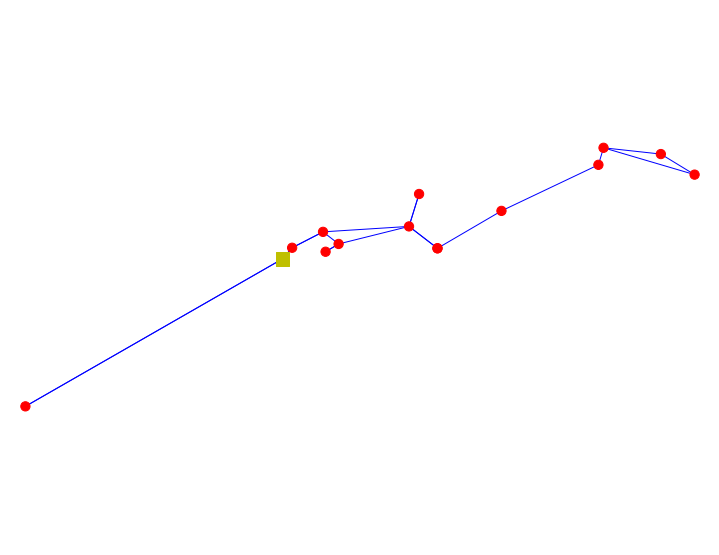

In [145]:
pp.plotting.simple_plot(net, respect_switches=False, line_width=1.0, bus_size=1.0, ext_grid_size=1.0, trafo_size=1.0,\
                        plot_loads=False, plot_sgens=False, load_size=1.0, sgen_size=1.0, switch_size=2.0, switch_distance=1.0,\
                        plot_line_switches=False, scale_size=True, bus_color='r', line_color='b', trafo_color='k', ext_grid_color='y',\
                        switch_color='k', library='igraph', show_plot=True, ax=None)

### Selection of data to extract and visualise

In [146]:
Interconnector_Power = HVDC_Interconnector_Flows.iloc[:,1]
#Interconnector_Power

In [147]:
#fig, ax = plt.subplots()
#plt.gcf().set_size_inches(20,12)
#ax.plot(Interconnector_Power)

In [148]:
Average_Line_Loading

,Time,Average Line Loading
0,0.0,36.034655
1,1.0,32.921984
2,2.0,30.749820
3,3.0,29.380869
4,4.0,28.770427
5,5.0,28.752563
6,6.0,29.190733
7,7.0,10.883489
8,8.0,13.204677
9,9.0,22.222131


In [149]:
t = Individual_Line_Loading.transpose() #to get appropriate line loading % plot 
t.columns = t.iloc[0]
t.drop(t.index[0], inplace = True)
#t

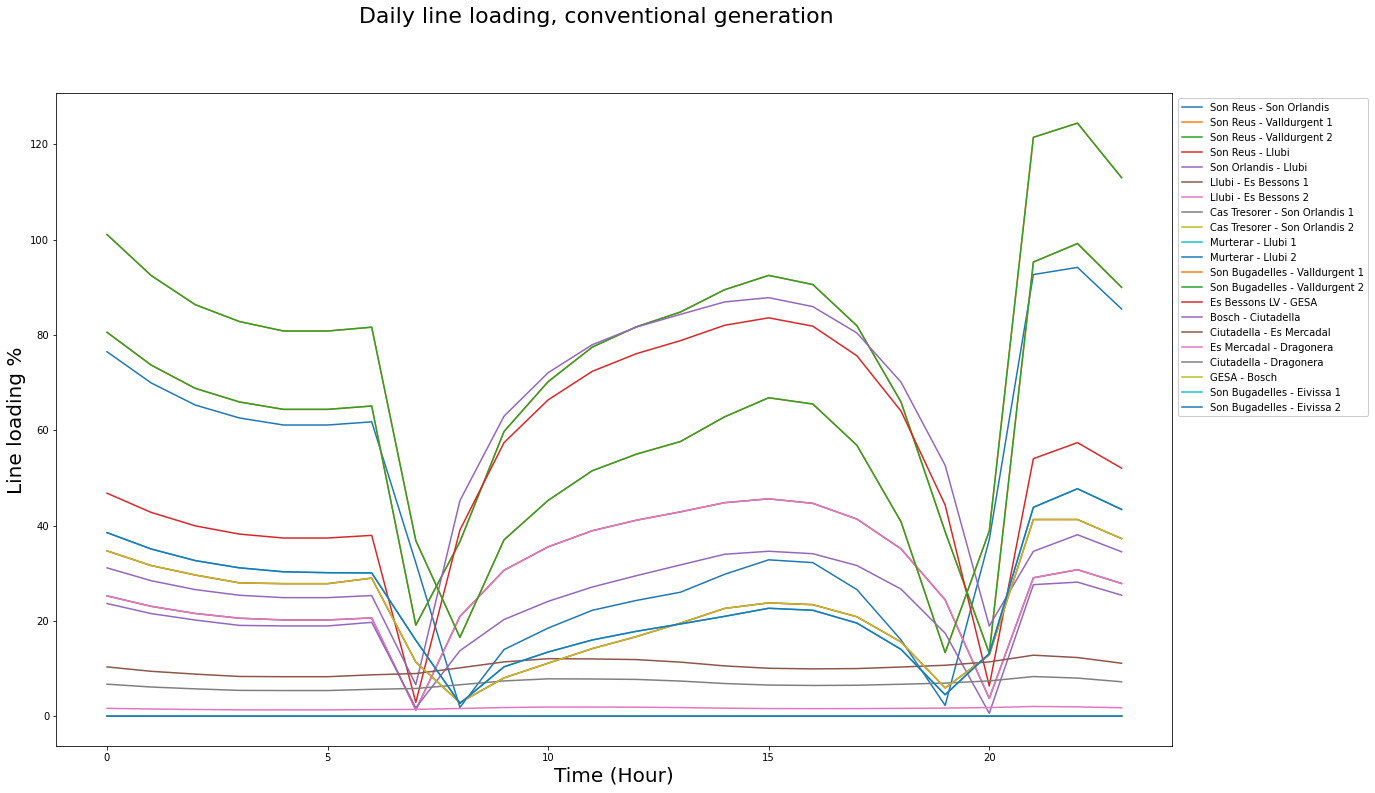

In [150]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(20,12)

for line in t:
     ax.plot(t[line].values, label='%s' %line)

    
ax.legend(loc = 1, framealpha = 1, bbox_to_anchor=(1.18, 1))
fig.suptitle("Daily line loading, conventional generation", fontsize=22)
ax.set_xlabel('Time (Hour)', fontsize = 20)
ax.set_ylabel('Line loading %', fontsize= 20)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

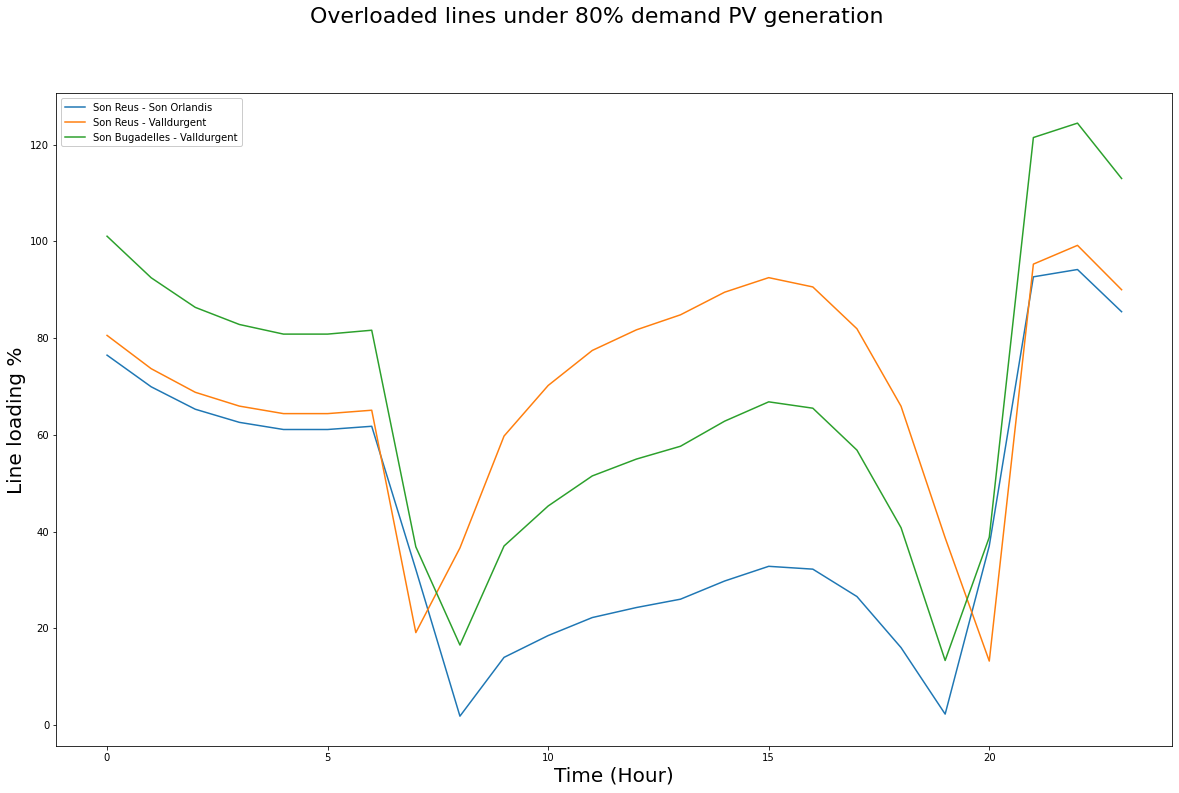

In [151]:
#high loads conventional generation
CT_SO = t.iloc[:,7]
SB_Ei = t.iloc[:,19]
SO_Ll = t.iloc[:,4]
#high loading under PV generation
SR_SO = t.iloc[:,0]
SR_Va = t.iloc[:,1]
SB_Va = t.iloc[:,11]

if PV_System_Installed is True:
    
    fig, ax = plt.subplots()
    plt.gcf().set_size_inches(20,12)
    
    ax.plot(SR_SO.values, label='%s' %'Son Reus - Son Orlandis')
    ax.plot(SR_Va.values, label='%s' %'Son Reus - Valldurgent')
    ax.plot(SB_Va.values, label='%s' %'Son Bugadelles - Valldurgent')
    
    ax.legend(loc = 2, framealpha = 1)
    fig.suptitle("Overloaded lines under 80% demand PV generation", fontsize=22)
    ax.set_xlabel('Time (Hour)', fontsize = 20)
    ax.set_ylabel('Line loading %', fontsize= 20)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
else:
    fig, ax = plt.subplots()
    plt.gcf().set_size_inches(20,12)
    
    
    ax.plot(CT_SO.values, label='%s' %'Cas Tresorer - Son Orlandis')
    ax.plot(SB_Ei.values, label='%s' %'Son Bugadelles - Eivissa')
    ax.plot(SO_Ll.values, label='%s' %'Son Orlandis - Llubi')
    
    ax.legend(loc = 2, framealpha = 1)
    fig.suptitle("Highest loading lines under conventional generation", fontsize=22)
    ax.set_xlabel('Time (Hour)', fontsize = 20)
    ax.set_ylabel('Line loading %', fontsize= 20)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()